**Recognize Handwritten Digits with TensorFlow**

https://www.digitalocean.com/community/tutorials/how-to-build-a-neural-network-to-recognize-handwritten-digits-with-tensorflow

In this tutorial, you will implement a small subsection of object recognition—digit recognition. Using TensorFlow, an open-source Python library developed by the Google Brain labs for deep learning research, you will take hand-drawn images of the numbers 0-9 and build and train a neural network to recognize and predict the correct label for the digit displayed. 

## Step 1 — Configuring the Project

In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.examples.tutorials.mnist import input_data

Instructions for updating:
non-resource variables are not supported in the long term


## Step 2 — Importing the MNIST Dataset

http://yann.lecun.com/exdb/mnist/

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  # y labels are oh-encoded

Instructions for updating:
Please use alternatives such as: tensorflow_datasets.load('mnist')
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/_DataSet.py from tensorflow/models.


In [3]:
mnist

_Datasets(train=<tensorflow.examples.tutorials.mnist.input_data._DataSet object at 0x000001E1320D0A58>, validation=<tensorflow.examples.tutorials.mnist.input_data._DataSet object at 0x000001E13A632710>, test=<tensorflow.examples.tutorials.mnist.input_data._DataSet object at 0x000001E13B7B3EB8>)

In [4]:
n_train = mnist.train.num_examples  # 55,000
n_validation = mnist.validation.num_examples  # 5000
n_test = mnist.test.num_examples  # 10,000

In [5]:
len(mnist.test.images[3301:6601])

3300

## Step 3 — Defining the Neural Network Architecture

神经网络的结构是指诸如网络中的层数、每层中的单元数以及单元之间如何连接等要素。由于神经网络从人类大脑的工作方式中得到了一些启发，所以在这里，“单位”一词被用来表示我们从生物学角度上认为的神经元。就像神经元在大脑中传递信号一样，单元从以前的单元中获取一些值作为输入，执行计算，然后将新值作为输出传递给其他单元。

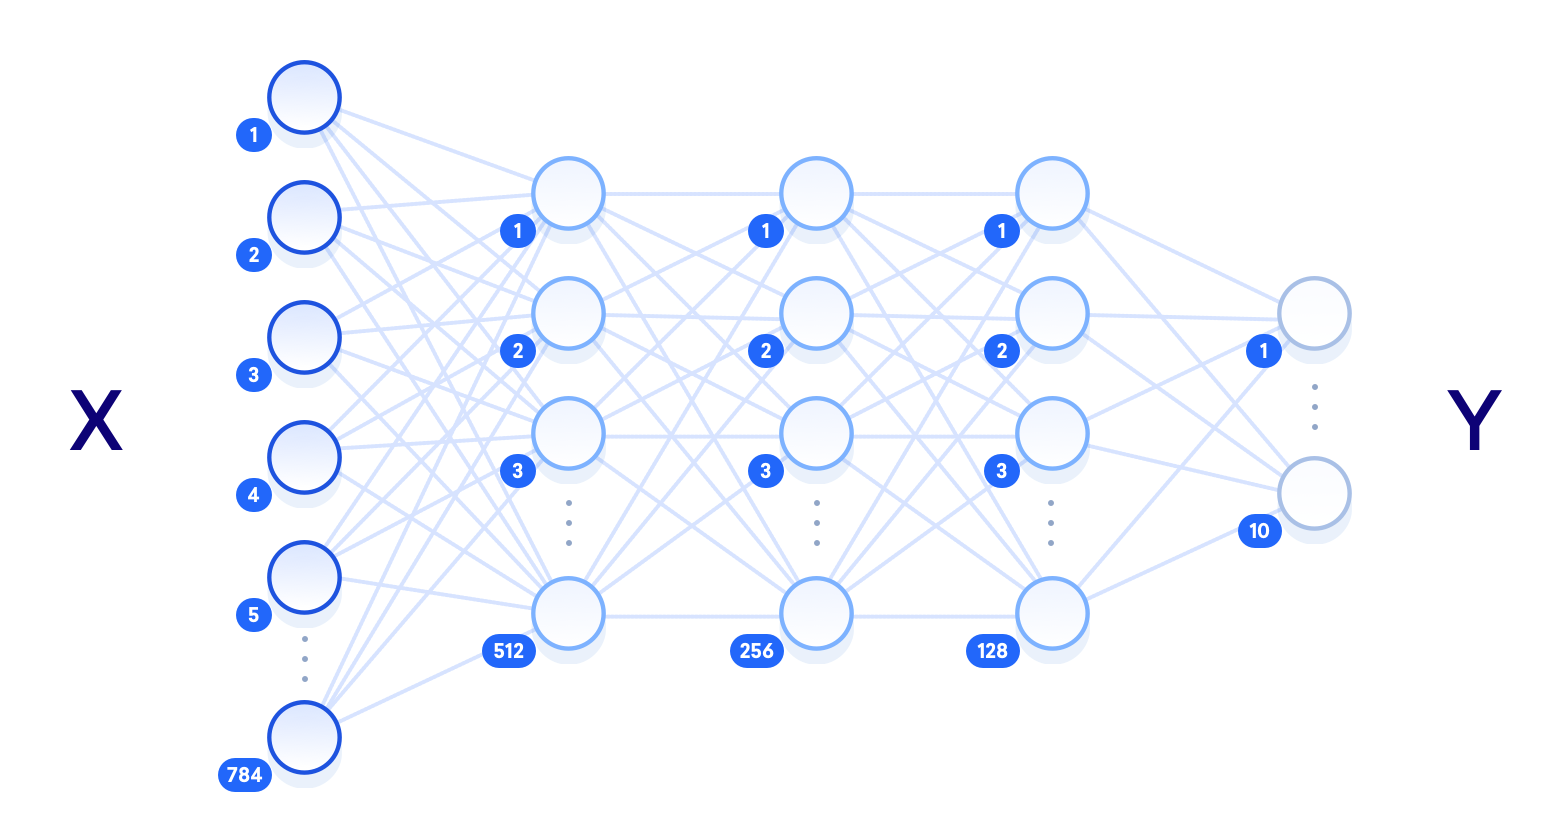

术语“深层神经网络”指的是隐藏层的数量，“浅层”通常指的是一个隐藏层，“深层”指的是多个隐藏层。如果有足够的训练数据，具有足够数量单元的浅神经网络理论上应该能够表示深度神经网络能够表示的任何函数。

但是，使用一个更小的深度神经网络来完成同样的任务通常在计算效率上更有效，而这需要一个具有指数级更多隐藏单元的浅层网络。浅层神经网络也经常遇到过拟合，即网络本质上是记忆它所见过的训练数据，而不能将知识推广到新的数据。

这就是为什么深度神经网络更常被使用的原因:原始输入数据和输出标签之间的多层允许网络学习不同抽象级别的特征，使网络本身能够更好地泛化。

In [6]:
n_input = 784  # input layer (28x28 pixels)
n_hidden1 = 512  # 1st hidden layer
n_hidden2 = 256  # 2nd hidden layer
n_hidden3 = 128  # 3rd hidden layer
n_output = 10  # output layer (0-9 digits)

学习率表示在学习过程的每一步中参数的调整量。这些调整是训练的一个关键组成部分:每次通过网络后，我们稍微调整重量，试图减少损失。较大的学习率可以更快地收敛，但也有可能在更新时超过最优值。

迭代次数指的是我们通过训练步骤的次数，批处理大小指的是我们在每个步骤中使用的训练实例的数量

dropout变量表示一个阈值，在这个阈值处我们随机删除一些单元。我们将使用dropout在我们的最后一个隐藏层，让每个单位有50%的机会被淘汰在每一个训练步骤。这有助于防止过度拟合。

In [7]:
# hyperparameters
learning_rate = 1e-4
n_iterations = 1000
batch_size = 128
dropout = 0.5

## Step 4 — Building the TensorFlow Graph

为了构建我们的网络，我们将把网络设置为TensorFlow要执行的计算图。TensorFlow的核心概念是张量，一种类似于数组或列表的数据结构。初始化，在通过图形时操作，并在学习过程中更新。

惟一需要在其声明中指定的参数是我们将输入的数据的大小。对于X，我们使用[None, 784]的形状，其中None表示任何数量，因为我们将输入未定义数量的784像素图像。Y的形状是[None, 10]，因为我们将使用它来处理未定义数量的标签输出，有10个可能的类。

The keep_prob tensor is used to control the dropout rate, and we initialize it as a placeholder rather than an immutable variable because we want to use the same tensor both for training (when dropout is set to 0.5) and testing (when dropout is set to 1.0).

In [8]:
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
keep_prob = tf.placeholder(tf.float32)

网络将在训练过程中更新的参数是权重和偏差值，因此对于这些我们需要设置一个初始值，而不是一个空的占位符。这些值本质上是网络进行学习的地方，因为它们被用于神经元的激活功能，代表单元之间连接的强度。

因为这些值是在训练期间优化的，所以我们现在可以将它们设置为0。但是初始值实际上对模型的最终精度有很大的影响。我们将使用截断的正态分布中的随机值作为权值。我们想让它们接近于零，这样它们就可以在正方向或负方向上进行调整，稍微有些不同，所以它们会产生不同的误差。这将确保模型学习到一些有用的东西。

对于偏置，我们使用一个小的常数值来确保张量在初始阶段激活，从而有助于传播。为了便于访问，权值和偏置张量存储在字典对象中。

In [9]:
weights = {
    'w1': tf.Variable(tf.truncated_normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.truncated_normal([n_hidden2, n_hidden3], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([n_hidden3, n_output], stddev=0.1)),
}

In [10]:
biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(0.1, shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(0.1, shape=[n_hidden3])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_output]))
}

接下来，通过定义操作张量的操作来设置网络的层。

每个隐层将对前一层的输出和当前层的权值执行矩阵乘法，并将偏差添加到这些值上。在最后一个隐藏层，我们将使用我们的keep_prob值0.5应用一个dropout操作。

In [32]:
layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
layer_drop = tf.nn.dropout(layer_3, rate = 1-keep_prob)
output_layer = tf.matmul(layer_drop, weights['out']) + biases['out']

构建图的最后一步是定义要优化的损失函数。在TensorFlow程序中，一个常见的损失函数选择是交叉熵，也称为对数损失，它量化了两个概率分布(预测和标签)之间的差异。一个完美的分类将导致交叉熵为0，损失完全最小化

我们还需要选择优化算法来最小化损失函数。一个称为梯度下降优化的过程是一种常见的方法，通过沿着梯度负(下降)方向的迭代步骤来找到一个函数的(局部)最小值。

在TensorFlow中已经实现了几种梯度下降优化算法，在本教程中，我们将使用Adam optimizer。这是梯度下降优化的延伸，通过计算梯度的指数加权平均值并在调整中使用动量来加速过程。

In [33]:
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=Y, logits=output_layer
        ))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

## Step 5 — Training and Testing

训练过程包括通过图形输入训练数据集和优化损失函数。每当网络遍历一批更多的训练图像时，它都会更新参数以减少损失，从而更准确地预测显示的数字。测试过程包括通过经过训练的图运行我们的测试数据集，并跟踪正确预测的图像数量，以便我们能够计算准确性。

在开始培训过程之前，我们将定义评估准确性的方法，以便在培训期间将其打印在小批量数据上。这些打印的语句将允许我们检查从第一次迭代到最后一次迭代，损失减少了，准确性增加了;它们还允许我们跟踪我们是否运行了足够的迭代以达到一致的和最优的结果

在correct_pred中，我们使用arg_max函数通过查看output_layer (predicted)和Y (label)来比较哪些图像被正确预测，并使用equal函数将其作为布尔值列表返回。然后我们可以将这个列表转换为浮点数，并计算平均值以获得总精度分数。

In [34]:
correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

现在，我们准备初始化一个会话来运行图形。在这节课中，我们将向网络提供我们的训练示例，一旦训练完毕，我们将向相同的图提供新的测试示例，以确定模型的准确性。

In [35]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

深度学习训练过程的本质是优化损失函数。这里我们的目标是最小化图像的预测标签和真实标签之间的差异。这个过程包括四个步骤，每个步骤重复若干次:
- 通过网络向前传播值
- 计算损失
- 通过网络反向传播值
- 更新参数

在每个训练步骤中，对参数进行轻微调整，以尝试减少下一步的损失。随着学习的进展，我们应该看到损失的减少，最终我们可以停止培训，使用网络作为测试新数据的模型。

在每个训练步骤的100次迭代之后，我们通过网络提供一小批图像，然后打印出该批图像的损失和准确性。注意，我们不应该期望在这里减少损失和增加准确性，因为值是每批的，而不是整个模型。我们使用小批量的图像，而不是逐个输入，以加快训练过程，并允许网络在更新参数之前看到许多不同的示例。

In [36]:
# train on mini batches
for i in range(n_iterations):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={
        X: batch_x, Y: batch_y, keep_prob: dropout
        })

    # print loss and accuracy (per minibatch)
    if i % 100 == 0:
        minibatch_loss, minibatch_accuracy = sess.run(
            [cross_entropy, accuracy],
            feed_dict={X: batch_x, Y: batch_y, keep_prob:1.0}
            )
        print(
            "Iteration",
            str(i),
            "\t| Loss =",
            str(minibatch_loss),
            "\t| Accuracy =",
            str(minibatch_accuracy)
            )

Iteration 0 	| Loss = 3.9641738 	| Accuracy = 0.0703125
Iteration 100 	| Loss = 0.7182763 	| Accuracy = 0.78125
Iteration 200 	| Loss = 0.49622715 	| Accuracy = 0.859375
Iteration 300 	| Loss = 0.28781196 	| Accuracy = 0.9375
Iteration 400 	| Loss = 0.40219158 	| Accuracy = 0.8984375
Iteration 500 	| Loss = 0.3954395 	| Accuracy = 0.890625
Iteration 600 	| Loss = 0.3399711 	| Accuracy = 0.8984375
Iteration 700 	| Loss = 0.25203073 	| Accuracy = 0.890625
Iteration 800 	| Loss = 0.2578561 	| Accuracy = 0.8984375
Iteration 900 	| Loss = 0.35936722 	| Accuracy = 0.875


In [37]:
test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images[3301:6601], Y: mnist.test.labels[3301:6601], keep_prob: 1.0})
print("\nAccuracy on test set:", test_accuracy)


Accuracy on test set: 0.90636367


为了尝试并提高我们的模型的准确性，或者了解更多关于调优超参数的影响，我们可以测试改变学习率、退出阈值、批大小和迭代次数的效果。我们也可以改变隐藏层的单位数量，改变隐藏层的数量，来观察不同的架构如何增加或减少模型的准确性

为了演示网络实际上是识别手绘图像的，让我们在自己的单个图像上测试它。

In [35]:
import numpy as np
from PIL import Image

First, we use the convert function with the L parameter to reduce the 4D RGBA representation to one grayscale color channel. We store this as a numpy array and invert it using np.invert, because the current matrix represents black as 0 and white as 255, whereas we need the opposite. Finally, we call ravel to flatten the array. 

In [36]:
img = np.invert(Image.open("test.jpg").convert('L')).ravel()

In [40]:
# len(img)

9980928

In [42]:
# prediction = sess.run(tf.argmax(output_layer, 1), feed_dict={X: [img]})
# print ("Prediction for test image:", np.squeeze(prediction))

## HOMEWORK

### Question 1

Explain the advantages and the disadvantages of the chosen optimization algorithm, “stochastic gradient descent”.  (The Adam optimizer extends stochastic gradient descent optimization.)

### Question 2
Do not test your accuracy against the entire test set as shown in the tutorial.  If you are ML group 1, test accuracy for the first 3300 data points in the test set, if you are ML group 2, test accuracy for data points 3301 to 6600 and if you are ML group 3, test accuracy for data points 6601 till the end.  Again, ML group 4 will use till 3300, ML group 5 points 3301 to 6600, and so on. 

### Question 3

Re-do the entire exercise but without using the dropouts from the final layer.  Calculate accuracy of your new model and compare against your previously achieved accuracy.  What is your conclusion?  Please also explain the intuition behind dropouts. 


https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/

In [9]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)  # y labels are oh-encoded
n_input = 784  # input layer (28x28 pixels)
n_hidden1 = 512  # 1st hidden layer
n_hidden2 = 256  # 2nd hidden layer
n_hidden3 = 128  # 3rd hidden layer
n_output = 10  # output layer (0-9 digits)

# hyperparameters
learning_rate = 1e-4
n_iterations = 1000
batch_size = 128
# dropout = 0.5

X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
keep_prob = tf.placeholder(tf.float32)

weights = {
    'w1': tf.Variable(tf.truncated_normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.truncated_normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.truncated_normal([n_hidden2, n_hidden3], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal([n_hidden3, n_output], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(0.1, shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(0.1, shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(0.1, shape=[n_hidden3])),
    'out': tf.Variable(tf.constant(0.1, shape=[n_output]))
}

layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
# layer_drop = tf.nn.dropout(layer_3, keep_prob)
output_layer = tf.matmul(layer_3, weights['out']) + biases['out']

cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=Y, logits=output_layer
        ))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# train on mini batches
for i in range(n_iterations):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={
        X: batch_x, Y: batch_y , keep_prob: 1.0
        })

    # print loss and accuracy (per minibatch)
    if i % 100 == 0:
        minibatch_loss, minibatch_accuracy = sess.run(
            [cross_entropy, accuracy],
            feed_dict={X: batch_x, Y: batch_y, keep_prob: 1.0}
            )
        print(
            "Iteration",
            str(i),
            "\t| Loss =",
            str(minibatch_loss),
            "\t| Accuracy =",
            str(minibatch_accuracy)
            )

test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images[3301:6601], Y: mnist.test.labels[3301:6601], keep_prob: 1.0})
print("\nAccuracy on test set:", test_accuracy)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Iteration 0 	| Loss = 4.2260876 	| Accuracy = 0.0859375
Iteration 100 	| Loss = 0.51036406 	| Accuracy = 0.8359375
Iteration 200 	| Loss = 0.38016188 	| Accuracy = 0.890625
Iteration 300 	| Loss = 0.34858835 	| Accuracy = 0.890625
Iteration 400 	| Loss = 0.36673063 	| Accuracy = 0.8984375
Iteration 500 	| Loss = 0.32871178 	| Accuracy = 0.90625
Iteration 600 	| Loss = 0.40919045 	| Accuracy = 0.8828125
Iteration 700 	| Loss = 0.33661324 	| Accuracy = 0.8984375
Iteration 800 	| Loss = 0.3379966 	| Accuracy = 0.875
Iteration 900 	| Loss = 0.25517958 	| Accuracy = 0.9140625

Accuracy on test set: 0.90575755


### Question 4

What other conventional algorithm(s) could you have used for this task?  What was the advantage of using a neural network for this exercise, instead of any other potential conventional algorithms? 

### Question 5

Use a multinomial logistic regression model to achieve the same handwriting identification task and compare the out-of-sample accuracy against the results of the neural network. 